# Import libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
from utils.db import get_inspect_database_uri

# Connect to the database and get the blocks table

In [2]:
conn = create_engine(get_inspect_database_uri()).connect()
# post merge
query = f"SELECT * FROM blocks WHERE block_number > 15537393"
blocks_df = pd.DataFrame(conn.execute(text(query)))
blocks_df.head()

,block_number,miner_address,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
0,18000000,0xDAFEA492D9c6733ae3d56b7Ed1ADB60692c98Bc5,0,2.1721091641E-8,0.03069720750085725,16247211,30000000
1,18000001,0x4838B106FCe9647Bdf1E7877BF73cE8B0BAD5f97,0,2.1946848177E-8,0.04992032653149086,12312027,30000000
2,18000002,0x95222290DD7278Aa3Ddd389Cc1E1d165CC4BAfe5,0,2.1455243716E-8,0.09338560279371551,11715790,30000000
3,18000003,0xe0D082bFE96cFb4A6dB758368FCA9E6028535C61,0,2.0868047667E-8,0.03696010240970883,13873956,30000000
4,18000004,0x1f9090aaE28b8a3dCeaDf281B0F12828e676c326,0,2.0672228169E-8,0.08028359615155437,12354288,30000000


# Preprocess the data
 
Fix column types and sort by block number

In [4]:
blocks_df.sort_values(by="block_number", ascending=True, inplace=True)
# convert block gas fee to float
blocks_df["gas_fee"] = blocks_df["gas_fee"].astype(float)
blocks_df["coinbase_transfer"] = blocks_df["coinbase_transfer"].astype(float)
blocks_df["gas_limit"] = blocks_df["gas_limit"].astype(float)
blocks_df["base_fee_per_gas"] = blocks_df["base_fee_per_gas"].astype(float)
blocks_df["gas_used"] = blocks_df["gas_used"].astype(float)

In [5]:
blocks_df.describe()

,block_number,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
count,2.092888e+06,2.092888e+06,2.092888e+06,2.092888e+06,2.092888e+06,2.092888e+06
mean,1.660855e+07,5.354570e-03,2.579679e-08,8.178891e-02,1.516569e+07,2.999988e+07
std,6.538174e+05,7.682735e+00,2.344238e-08,4.132008e-01,6.376657e+06,1.989706e+03
min,1.553739e+07,0.000000e+00,1.706518e-09,0.000000e+00,0.000000e+00,2.988296e+07
25%,1.606062e+07,0.000000e+00,1.320134e-08,2.394867e-02,1.120080e+07,3.000000e+07
50%,1.658384e+07,0.000000e+00,1.913589e-08,3.937706e-02,1.390722e+07,3.000000e+07
75%,1.710706e+07,0.000000e+00,3.043531e-08,7.381128e-02,1.792536e+07,3.000000e+07
max,1.839079e+07,1.111441e+04,8.132266e-07,1.695329e+02,3.002512e+07,3.002930e+07


In [20]:
# Get the row with max gas fee
normal_blocks = blocks_df[(blocks_df["gas_fee"] < 7.381128e-02)]
normal_blocks.describe()

,block_number,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
count,1.569666e+06,1.569666e+06,1.569666e+06,1.569666e+06,1.569666e+06,1.569666e+06
mean,1.656433e+07,7.130869e-03,2.162410e-08,3.340797e-02,1.431310e+07,2.999987e+07
std,6.464352e+05,8.871254e+00,1.565960e-08,1.703381e-02,6.233612e+06,2.075279e+03
min,1.553740e+07,0.000000e+00,1.706518e-09,0.000000e+00,0.000000e+00,2.988296e+07
25%,1.605081e+07,0.000000e+00,1.263324e-08,2.067851e-02,1.062438e+07,3.000000e+07
50%,1.650446e+07,0.000000e+00,1.732717e-08,3.077916e-02,1.323571e+07,3.000000e+07
75%,1.699918e+07,0.000000e+00,2.601334e-08,4.497429e-02,1.683775e+07,3.000000e+07
max,1.839079e+07,1.111441e+04,6.748298e-07,7.381122e-02,3.002512e+07,3.002930e+07


In [36]:
NAIVE = 0
ESCROW = 1

def calculate_congestion_cost(method, block_range, gas_price, gas_usage, base_fee_per_gas):
    cost = 0
    if method == NAIVE:
        for block in range(block_range):
            cost += (gas_price + base_fee_per_gas) * 30e6
            base_fee_per_gas = base_fee_per_gas * (1 + 1/8) # 12.5% increase for full blocks
    elif method == ESCROW:
        for block in range(block_range):
            cost += (gas_price + base_fee_per_gas) * gas_usage
            base_fee_per_gas = base_fee_per_gas * (1 - 1/8)
            # base_fee_per_gas = base_fee_per_gas * (1 - 1/8*(tx_gas_usage - target)/target)
    
    return cost

In [32]:
# Calculate the congestion cost for the naive method
mean_reward = 3.340797e-02
mean_gas_usage = 1.431310e+07
mean_base_fee_per_gas = 2.162410e-08
mean_gas_price = mean_reward / mean_gas_usage

for block_range in [1, 2, 5, 10, 50, 100]:
    naive_cost = calculate_congestion_cost(NAIVE, block_range, mean_gas_price, 30e6, mean_base_fee_per_gas)
    print(f"Naive cost for {block_range} blocks: {naive_cost}")
    

Naive cost for 1 blocks: 0.7187455038601003
Naive cost for 2 blocks: 1.5185813827202006
Naive cost for 5 blocks: 4.5124878032360485
Naive cost for 10 blocks: 12.363335739440545
Naive cost for 50 blocks: 1872.3364489047738
Naive cost for 100 blocks: 676710.150295881


In [35]:
# Calculate the congestion cost for the escrow method 
for block_range in [1, 2, 5, 10, 50, 100, 1000]:
    escrow_cost = calculate_congestion_cost(ESCROW, block_range, mean_gas_price, mean_gas_usage, mean_base_fee_per_gas)
    print(f"Escrow cost for {block_range} blocks: {escrow_cost}")

Escrow cost for 1 blocks: 0.34291587571000004
Escrow cost for 2 blocks: 0.6471432632062502
Escrow cost for 5 blocks: 1.373108131991531
Escrow cost for 10 blocks: 2.1587511807046553
Escrow cost for 50 blocks: 4.143341675342177
Escrow cost for 100 blocks: 5.816856314100737
Escrow cost for 1000 blocks: 35.88403324567949


# Gas fee fluctuations

<Axes: xlabel='block_number'>

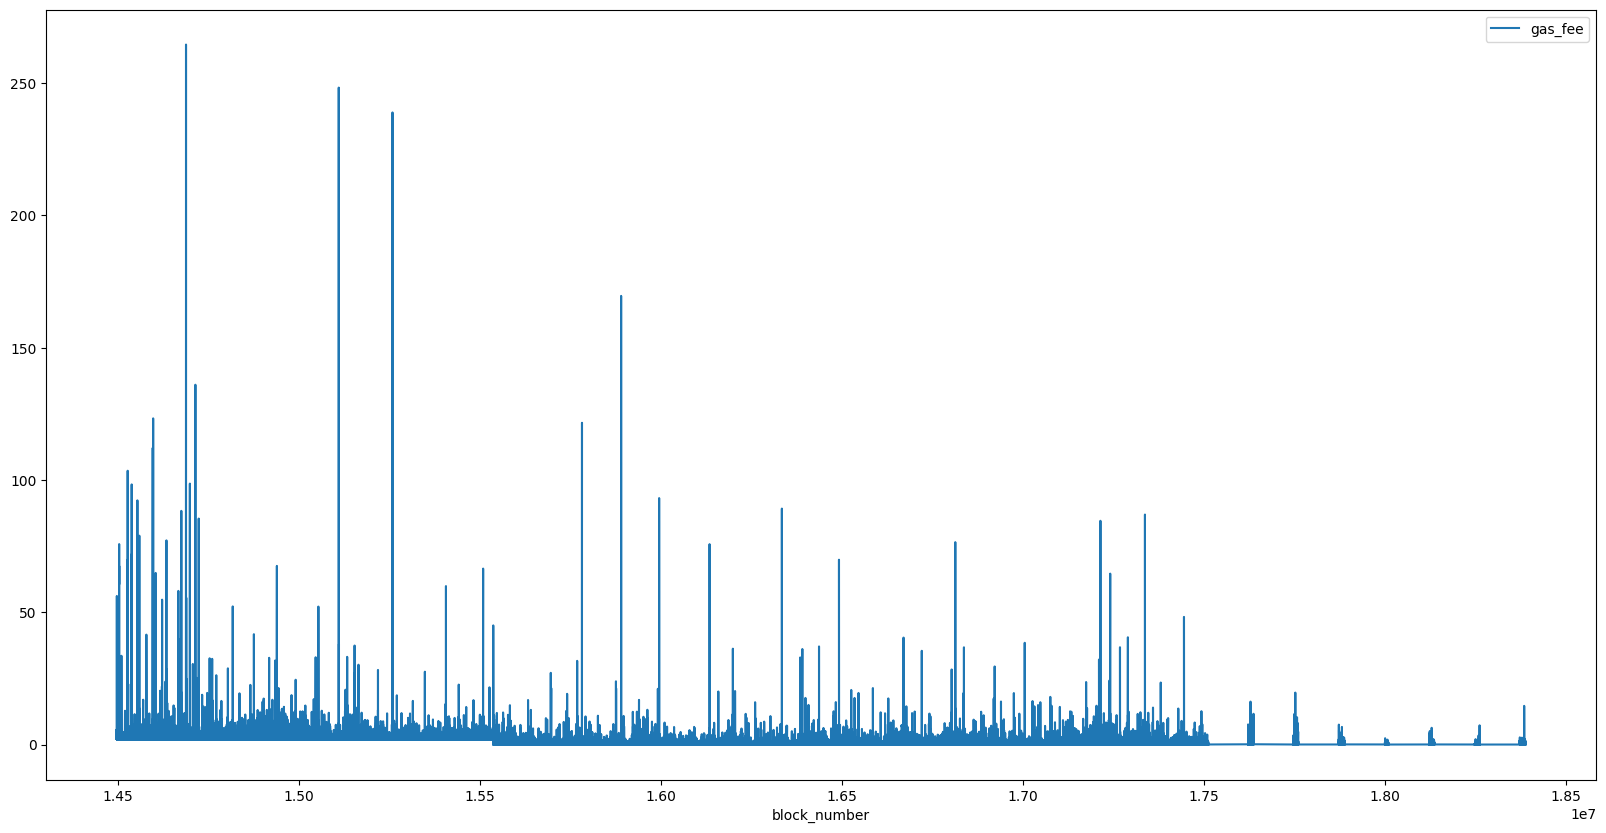

In [4]:
# Plot the gas fee per block
blocks_df.plot(x="block_number", y="gas_fee", kind="line", figsize=(20, 10))

In [5]:
# Get the blocks where there is a spike in gas fees
blocks_df[blocks_df["gas_fee"] > 100]

,block_number,miner_address,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
167078,14527758,0x829BD824B016326A401d083B33D092293333A830,0.0,1.720893e-07,103.472468,30133363.0,30137112.0
623093,14596875,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,3.327335e-08,112.092118,30105877.0,30107595.0
631560,14598132,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,2.556078e-08,123.261897,30109325.0,30117210.0
460388,14688877,0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836,0.0,1.917428e-07,154.744804,29996997.0,30000000.0
460389,14688878,0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c,0.0,2.157058e-07,120.931367,30028995.0,30029295.0
460390,14688879,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0.0,2.426685e-07,179.623885,29990964.0,30000000.0
460391,14688880,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0.0,2.729838e-07,264.505817,29991554.0,30000000.0
460392,14688881,0xc730B028dA66EBB14f20e67c68DD809FBC49890D,0.0,3.070876e-07,192.833025,29989508.0,30000000.0
460393,14688882,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,3.454467e-07,228.596515,30020156.0,30029295.0
460394,14688883,0x646dB8ffC21e7ddc2B6327448dd9Fa560Df41087,0.0,3.886012e-07,218.083680,29988605.0,29999971.0


1. 14527758: Vayner Sports Pass Purchase
2. 14596875: 0xStudio GPass Token Mint
3. 14598132: MoonBirds Token Mint
4. 14688877 - 14688903: OTHR Token Mint
5. 14714775: GHOST Token Mint
6. 15110688 & 15110689: SAUD Token Mint
7. 15259103: TODO: Get the transactions and check them
8. 15782459: TODO: Get the transactions and check them
9. 15890545 & 15890548: Keeper NFT Mint

# Base fee fluctuations

<Axes: xlabel='block_number'>

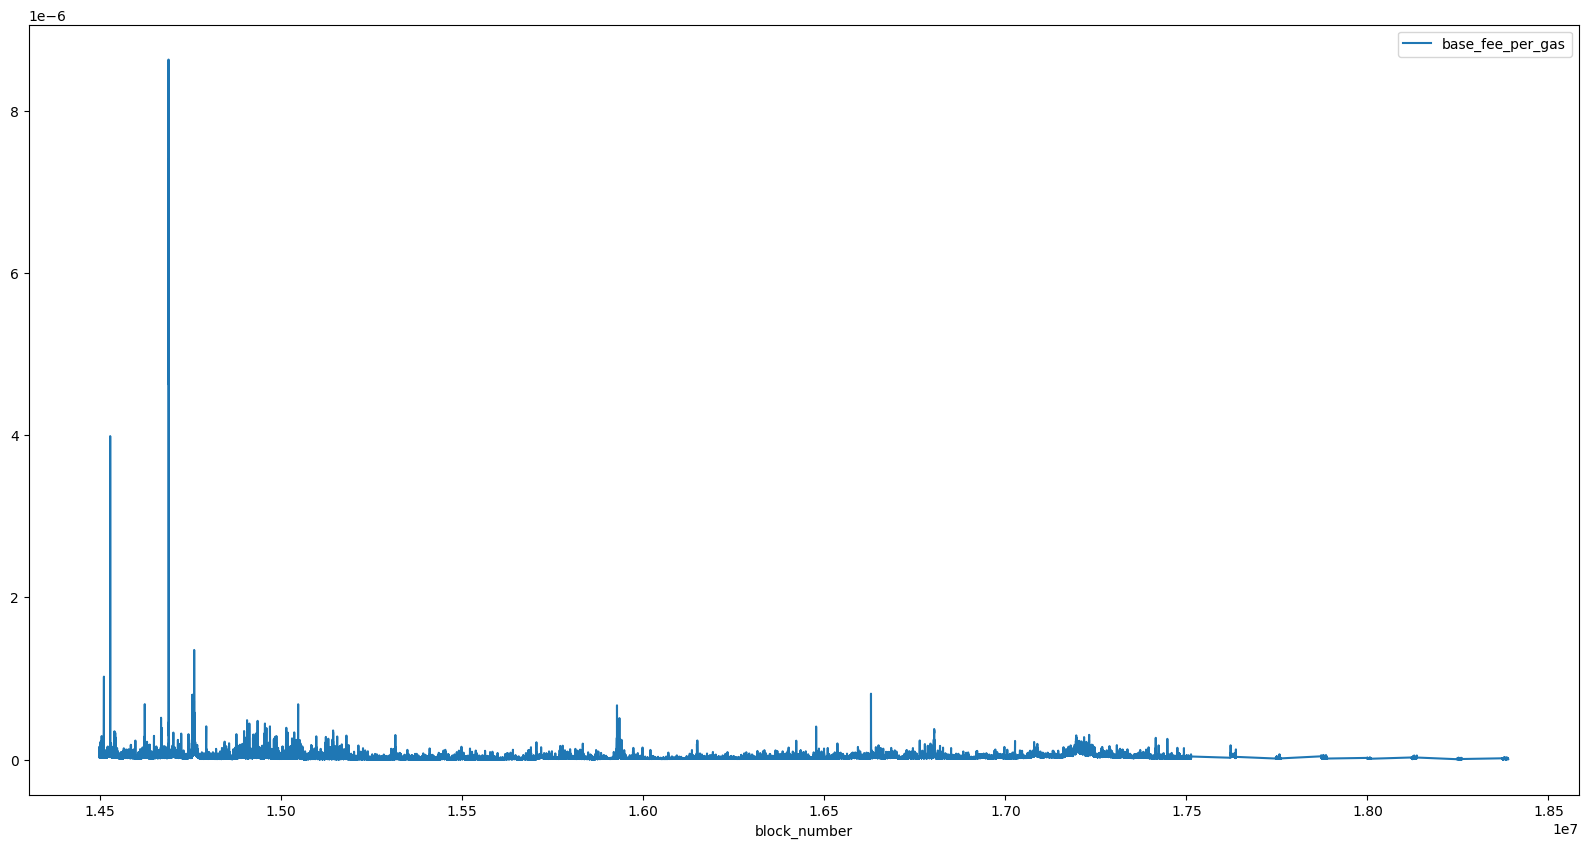

In [6]:
# Plot the base fee per gas per block
blocks_df.plot(x="block_number", y="base_fee_per_gas", kind="line", figsize=(20, 10))

In [4]:
# Get the mean of non-zero base fees
mean_base_fee = blocks_df[blocks_df["base_fee_per_gas"] > 0][
    "base_fee_per_gas"
].mean()
mean_base_fee

2.9537378972601317e-08

In [6]:
# Get the blocks where there is a spike in base fees
abnormal_base = blocks_df[blocks_df["base_fee_per_gas"] > mean_base_fee * 100]
# fetch the maximum base fee per each interval of abnormal base fees
abnormal_base

,block_number,miner_address,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
167105,14527785,0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8,0.0,0.000003,4.514901,15817702.0,30000000.0
167106,14527786,0xc730B028dA66EBB14f20e67c68DD809FBC49890D,0.0,0.000003,11.693052,10387469.0,30000000.0
167107,14527787,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,0.000003,16.668878,30011918.0,30029295.0
167108,14527788,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,0.000003,3.354986,3175216.0,30058619.0
167109,14527789,0x829BD824B016326A401d083B33D092293333A830,0.0,0.000003,2.106119,523223.0,30087972.0
...,...,...,...,...,...,...,...
466016,14689605,0x829BD824B016326A401d083B33D092293333A830,0.0,0.000003,11.699318,30037736.0,30058591.0
466017,14689606,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,0.000004,3.984836,12669000.0,30087944.0
466018,14689607,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,0.000003,3.458902,4308878.0,30117325.0
466019,14689608,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0,0.000003,2.288872,4159811.0,30146735.0


# Gas Used Fluctuations

In [16]:
blocks_df[blocks_df['gas_used'] > 30e6]

,block_number,miner_address,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
7,14497041,0x829BD824B016326A401d083B33D092293333A830,0.0,4.548057e-08,2.281967,30068421.0,30087915.0
218,14497062,0x829BD824B016326A401d083B33D092293333A830,0.0,3.434367e-08,2.263026,30050227.0,30058247.0
219,14497063,0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a,0.0,3.863434e-08,2.237673,30023218.0,30028895.0
223,14497067,0xB7e390864a90b7b923C9f9310C6F98aafE43F707,0.0,3.763973e-08,2.211079,30016268.0,30029295.0
309,14497083,0x8F03f1a3f10c05E7CCcF75C1Fd10168e06659Be7,0.0,4.114229e-08,2.222649,30018503.0,30019595.0
...,...,...,...,...,...,...,...
1686092,15869036,0xBc178995898b0f611B4360DF5AD653CdEBe6DE3F,0.0,3.492139e-08,0.781798,30017990.0,30029295.0
2006361,16129585,0x690B9A9E9aa1C9dB991C7721a92d351Db4FaC990,0.0,1.315385e-08,0.097154,30014972.0,30029295.0
2531246,16465891,0xd2090025857B9C7B24387741f120538E928A3a59,0.0,1.448248e-08,0.042356,30023764.0,30029295.0
1621995,17056536,0xd2090025857B9C7B24387741f120538E928A3a59,0.0,2.354113e-08,0.015279,30025119.0,30029295.0


In [37]:
# get the block with max gas used
low_gas_usage_df = blocks_df[(blocks_df['gas_used'] < 210000) & (blocks_df['gas_used'] > 200000)]

In [38]:
# Get the miner who mined the most blocks
low_gas_usage_df['miner_address'].value_counts()

miner_address
0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836    37
0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c    10
0x829BD824B016326A401d083B33D092293333A830     9
0x2DaA35962A6D43EB54C48367b33d0B379C930E5e     9
0xab3B229eB4BcFF881275E7EA2F0FD24eeaC8C83a     8
0x4675C7e5BaAFBFFbca748158bEcBA61ef3b0a263     5
0xd757fd54b273BB1234d4d9993f27699d28d0EDD2     5
0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8     4
0x388C818CA8B9251b393131C08a736A67ccB19297     3
0xe10332741c59CED2BA96db514a9eD865dDF99b6a     3
0xCD458d7F11023556cC9058F729831a038Cb8Df9c     3
0x03e75d7DD38CCE2e20FfEE35EC914C57780A8e29     2
0xB7e390864a90b7b923C9f9310C6F98aafE43F707     2
0x2A20380DcA5bC24D052acfbf79ba23e988ad0050     2
0xfF80562d2dc23E89194B868263De8E1987D34e72     1
0x26269a78ce602Ee7be227dB699749dC037506F01     1
0x2e95a71630F18856A4B9ce8B3B1567c38525281F     1
0x9f4B4CeCa7aCE96834Bd2fcC961c772De7cb481a     1
0x24d6C74D811cfDe65995Ed26FD08Af445f8aaB06     1
0xED17B22021295804Fb392b402c5833c256Df12d5     1
0x2746

In [41]:
# todo: check more
hiveon_blocks = blocks_df[blocks_df['miner_address'] == '0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836']

# Coinbase Transfers

In [26]:
blocks_df[blocks_df['coinbase_transfer'] > 0]

,block_number,miner_address,coinbase_transfer,base_fee_per_gas,gas_fee,gas_used,gas_limit
2329,14497443,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.9991835922379423,7.6177761301E-8,2.119218,17770440,30058591
17996,14500266,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0.0019114457863885,4.0334622966E-8,2.074198,18896935,30058619
60491,14508061,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0.095079497,6.2094479205E-8,2.538814,30008155,30029040
484364,14577455,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0.189430345,7.2658860835E-8,2.095611,17290602,30000000
760637,14617444,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0.473378505,5.0747505225E-8,2.250332,29959366,29970676
...,...,...,...,...,...,...,...
994774,16248329,0xeBec795c9c8bBD61FFc14A6662944748F299cAcf,0.000553518633866747,1.2507494468E-8,0.036302,10540649,30000000
994808,16248363,0x70eB4005510C109d71B30056E710B6C7450Fa6Ad,0.000744200482682364,1.1809105544E-8,0.027640,20771105,30000000
994816,16248371,0x4675C7e5BaAFBFFbca748158bEcBA61ef3b0a263,0.000572480170933355,1.3183873032E-8,0.043475,16177707,30000000
994819,16248374,0x388C818CA8B9251b393131C08a736A67ccB19297,0.000555392485322435,1.3385414333E-8,0.041669,16042133,30000000


In [32]:
# get the block number of the highest coinbase transfer
blocks_df[blocks_df['coinbase_transfer'] > 0].max()

block_number                                           16248377
miner_address        0xf8636377b7a998B51a3Cf2BD711B870B3Ab0Ad56
coinbase_transfer                                      1.411419
base_fee_per_gas                                            0.0
gas_fee                                                 2.62262
gas_used                                             30113686.0
gas_limit                                            30117353.0
dtype: object